In [2]:
import os, shutil, pathlib, numpy as np, pandas as pd, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns, cv2
from PIL import Image
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Dropout, Input,
                                     RandomFlip, RandomRotation, RandomZoom)
from tensorflow.keras.applications import VGG19, ResNet50, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

EDA

In [3]:
base_dir = pathlib.Path('C:/Tugas Kuliah/ML/tubes_fix/DatasetTrashnet/dataset-resized')

if not base_dir.exists():
    print(f"Error: Direktori dataset tidak ditemukan di {base_dir}")
    print("Pastikan dataset 'dataset-resized' sudah ada di dalam folder 'tubes_fix/DatasetTrashnet'.")
    exit()

all_filepaths = list(base_dir.glob('*/*.jpg'))
all_labels = [p.parent.name for p in all_filepaths]
df = pd.DataFrame({'filepath': [str(p) for p in all_filepaths], 'label': all_labels})

print(f"Total gambar ditemukan: {len(df)}")
print("\nLima baris pertama DataFrame:")
print(df.head())

Total gambar ditemukan: 2527

Lima baris pertama DataFrame:
                                            filepath      label
0  C:\Tugas Kuliah\ML\tubes_fix\DatasetTrashnet\d...  cardboard
1  C:\Tugas Kuliah\ML\tubes_fix\DatasetTrashnet\d...  cardboard
2  C:\Tugas Kuliah\ML\tubes_fix\DatasetTrashnet\d...  cardboard
3  C:\Tugas Kuliah\ML\tubes_fix\DatasetTrashnet\d...  cardboard
4  C:\Tugas Kuliah\ML\tubes_fix\DatasetTrashnet\d...  cardboard


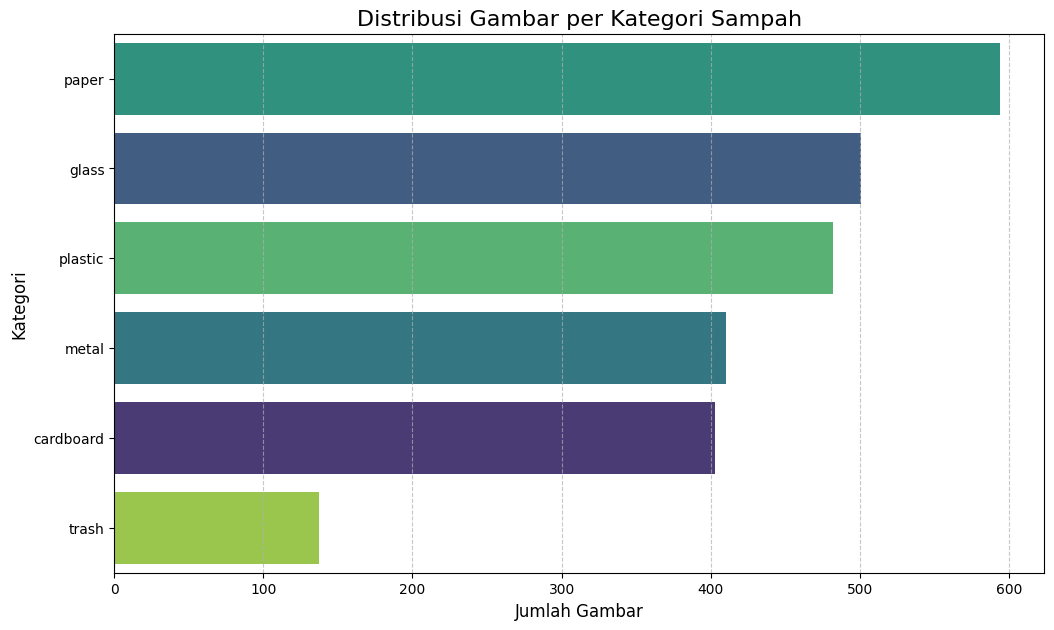

In [4]:
plt.figure(figsize=(12, 7))
sns.countplot(y=df['label'], order=df['label'].value_counts().index, hue=df['label'], palette='viridis', legend=False)
plt.title('Distribusi Gambar per Kategori Sampah', fontsize=16)
plt.xlabel('Jumlah Gambar', fontsize=12); plt.ylabel('Kategori', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

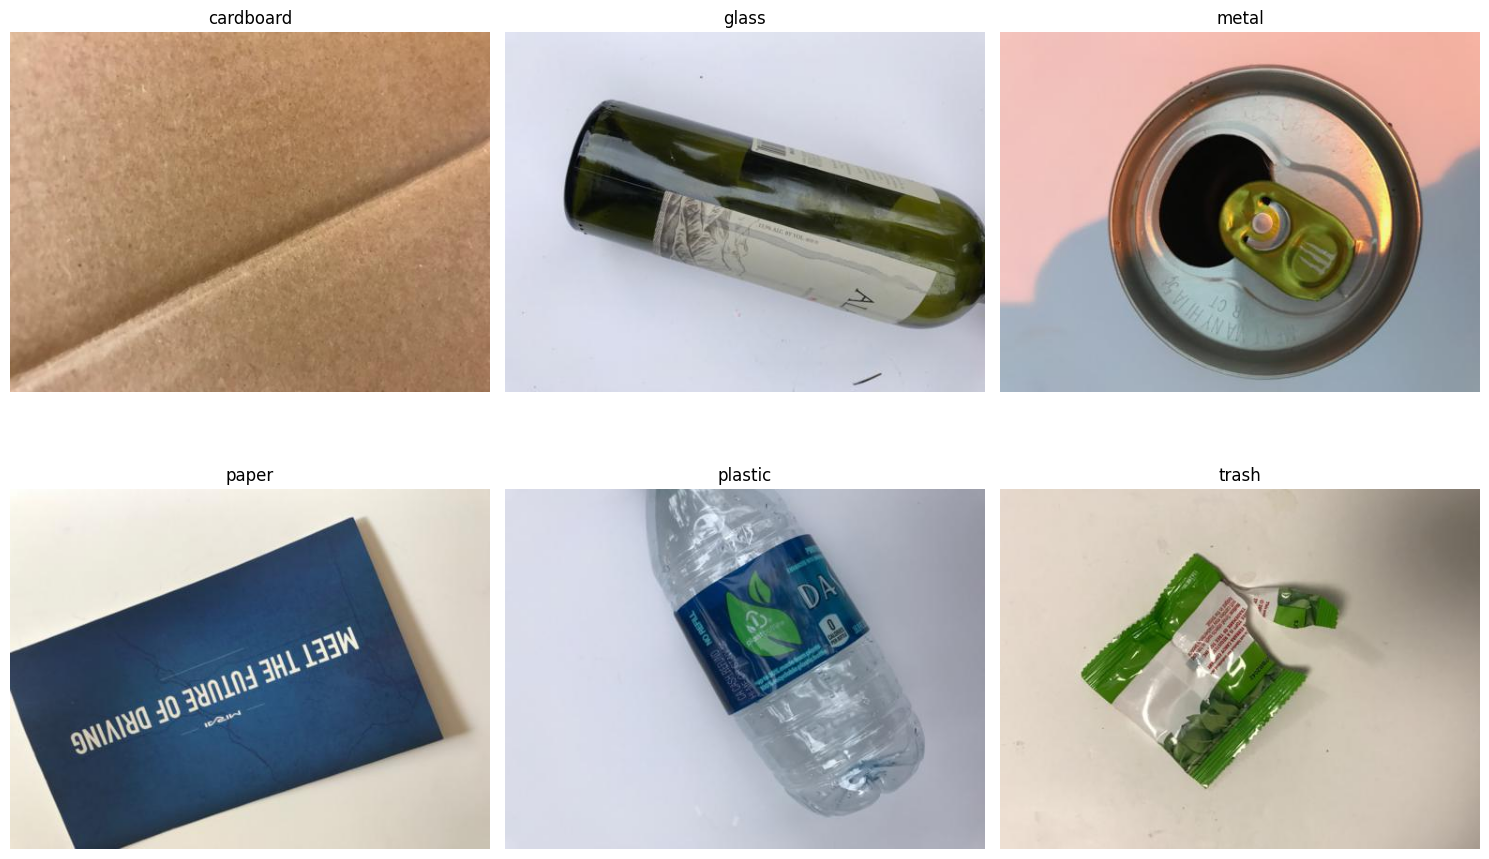

In [5]:
unique_labels = df['label'].unique()
plt.figure(figsize=(15, 10))
for i, label in enumerate(unique_labels):
    # Ambil 1 contoh gambar dari setiap kategori
    sample_path = df[df['label'] == label].sample(1)['filepath'].iloc[0]
    img = Image.open(sample_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
image_data = []
for f in all_filepaths:
    try:
        with Image.open(f) as img:
            width, height = img.size
        # Menggunakan OpenCV untuk metrik keburaman
        cv_img = cv2.imread(f)
        if cv_img is None: # Periksa jika gambar tidak dapat dimuat oleh OpenCV
            print(f"Warning: Tidak dapat memuat gambar {f} dengan OpenCV. Melewatkan metrik keburaman.")
            blur_metric = np.nan # Atau nilai default lainnya
        else:
            gray_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)
            blur_metric = cv2.Laplacian(gray_img, cv2.CV_64F).var()
        image_data.append({'filepath': str(f), 'width': width, 'height': height, 'aspect_ratio': width/height, 'blurriness': blur_metric})
    except Exception as e:
        print(f"Error memproses gambar {f}: {e}. Melewatkan gambar ini.")
        continue # Lanjutkan ke gambar berikutnya jika ada error

eda_df = pd.DataFrame(image_data)

In [7]:
print("\nStatistik Deskriptif Atribut Gambar:")
print(eda_df[['width', 'height', 'aspect_ratio', 'blurriness']].describe())


Statistik Deskriptif Atribut Gambar:
        width  height  aspect_ratio   blurriness
count  2527.0  2527.0  2.527000e+03  2527.000000
mean    512.0   384.0  1.333333e+00   334.563946
std       0.0     0.0  2.220886e-16   438.460365
min     512.0   384.0  1.333333e+00     2.049306
25%     512.0   384.0  1.333333e+00    69.752349
50%     512.0   384.0  1.333333e+00   172.978163
75%     512.0   384.0  1.333333e+00   404.254431
max     512.0   384.0  1.333333e+00  4127.156033


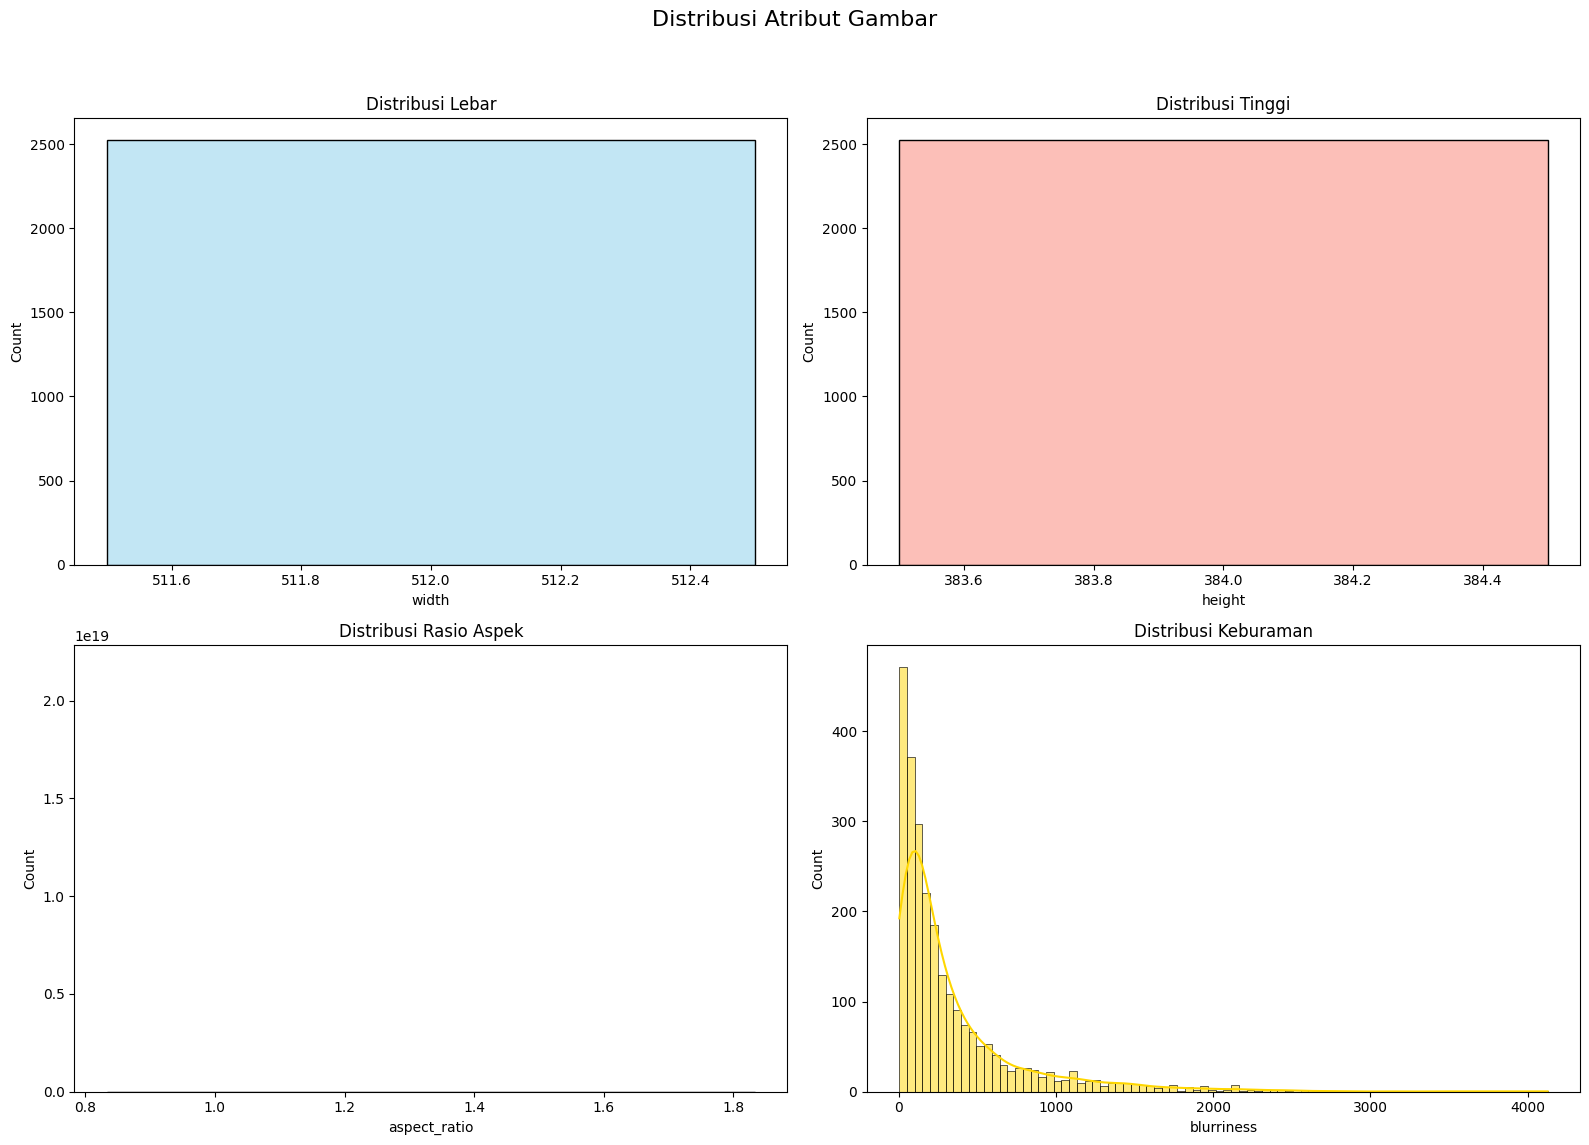

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribusi Atribut Gambar', fontsize=16)

sns.histplot(eda_df['width'].dropna(), kde=True, ax=axes[0, 0], color='skyblue').set_title('Distribusi Lebar')
sns.histplot(eda_df['height'].dropna(), kde=True, ax=axes[0, 1], color='salmon').set_title('Distribusi Tinggi')
sns.histplot(eda_df['aspect_ratio'].dropna(), kde=True, ax=axes[1, 0], color='lightgreen').set_title('Distribusi Rasio Aspek')
sns.histplot(eda_df['blurriness'].dropna(), kde=True, ax=axes[1, 1], color='gold').set_title('Distribusi Keburaman')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Preprocessing

In [9]:
IMG_SIZE = 224
BATCH_SIZE = 32
output_dir = pathlib.Path('data_split')
if output_dir.exists(): shutil.rmtree(output_dir)

train_df, remaining_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(remaining_df, test_size=1/6, random_state=42, stratify=remaining_df['label'])

def create_split_dirs(dataframe, split_name):
    for _, row in dataframe.iterrows():
        target_dir = output_dir / split_name / row['label']
        target_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(row['filepath'], target_dir)

print("Membuat direktori dan menyalin file untuk split data (train, validation, test)...")
create_split_dirs(train_df, 'train'); create_split_dirs(val_df, 'validation'); create_split_dirs(test_df, 'test')

train_ds = tf.keras.utils.image_dataset_from_directory(
    output_dir / 'train', labels='inferred', label_mode='categorical', image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=True)
val_ds = tf.keras.utils.image_dataset_from_directory(
    output_dir / 'validation', labels='inferred', label_mode='categorical', image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=False)
test_ds = tf.keras.utils.image_dataset_from_directory(
    output_dir / 'test', labels='inferred', label_mode='categorical', image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Kategori yang ditemukan: {class_names}")

data_augmentation = tf.keras.Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)), RandomFlip("horizontal"),
    RandomRotation(0.2), RandomZoom(0.2)], name="data_augmentation")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
class_weights_values = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weight_dict = dict(enumerate(class_weights_values))
print(f"Class weights: {class_weight_dict}")

Membuat direktori dan menyalin file untuk split data (train, validation, test)...
Found 2021 files belonging to 6 classes.
Found 421 files belonging to 6 classes.
Found 85 files belonging to 6 classes.
Kategori yang ditemukan: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class weights: {0: np.float64(1.0460662525879918), 1: np.float64(0.8399833748960931), 2: np.float64(1.026930894308943), 3: np.float64(0.7091228070175438), 4: np.float64(0.8748917748917749), 5: np.float64(3.062121212121212)}


In [10]:
def create_model(model_name, num_classes, img_size=224):
    input_shape = (img_size, img_size, 3)
    inputs = Input(shape=input_shape)

    if model_name == 'VGG19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape, name='base_model')
        x = tf.keras.applications.vgg19.preprocess_input(inputs)
        x = base_model(x, training=False)
    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, name='base_model')
        x = tf.keras.applications.resnet50.preprocess_input(inputs)
        x = base_model(x, training=False)
    elif model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape, name='base_model')
        base_model.load_weights('models/efficientnetb0_notop.h5')
        x = base_model(inputs, training=False)
    else:
        raise ValueError("Nama model tidak dikenal.")

    base_model.trainable = False

    x = GlobalAveragePooling2D(name="avg_pool")(x)
    x = Dropout(0.5, name="dropout")(x)
    outputs = Dense(num_classes, activation='softmax', name="output")(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

    print(f"Model {model_name} berhasil dibuat dengan struktur yang benar.")
    model.summary()
    
    return model

# Fungsi 2: plot_combined_history (sama seperti sebelumnya)
def plot_combined_history(initial_history, fine_tune_history, model_name):
    acc = initial_history.history['accuracy'] + fine_tune_history.history['accuracy']
    val_acc = initial_history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
    plt.figure(figsize=(8, 6))
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axvline(len(initial_history.history['accuracy']) - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
    plt.title(f'{model_name} Accuracy History', fontsize=14)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    plt.show()

# Fungsi 3: run_training_and_finetuning (sama seperti sebelumnya)
def run_training_and_finetuning(model, model_name, train_ds, val_ds, class_weight_dict):
    print(f"\nMemulai Proses Training untuk: {model_name}\n" + "-" * 50)
    # FASE 1: INITIAL TRAINING
    print("\nFASE 1: Initial Training...")
    os.makedirs("models", exist_ok=True)
    initial_train_checkpoint_path = f"models/{model_name}_initial_train_best.keras"
    callbacks_initial = [
        ModelCheckpoint(filepath=initial_train_checkpoint_path, save_best_only=True, monitor='val_accuracy', verbose=1),
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
        TensorBoard(log_dir=f"logs/fit/{model_name}_initial/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
    ]
    initial_history = model.fit(train_ds, epochs=80, validation_data=val_ds, callbacks=callbacks_initial, class_weight=class_weight_dict)
    print(f"Model terbaik dari training awal disimpan di: {initial_train_checkpoint_path}")

    # FASE 2: FINE-TUNING
    print(f"\nFASE 2: Fine-Tuning...")
    fine_tune_model = tf.keras.models.load_model(initial_train_checkpoint_path)
    
    base_model = fine_tune_model.get_layer('base_model')
    
    base_model.trainable = True
    fine_tune_at = {'VGG19': -4, 'ResNet50': -22, 'EfficientNetB0': -20}.get(model_name)
    for layer in base_model.layers[:fine_tune_at]: layer.trainable = False
    fine_tune_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks_finetune = [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
        TensorBoard(log_dir=f"logs/fit/{model_name}_finetune/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
    ]
    fine_tune_history = fine_tune_model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=callbacks_finetune)
    final_model_path = f"models/{model_name}_fine_tuned_final.keras"
    fine_tune_model.save(final_model_path)
    print(f"Model final setelah fine-tuning disimpan di: {final_model_path}")
    plot_combined_history(initial_history, fine_tune_history, model_name)
    return fine_tune_model

# Fungsi 4: evaluate_final_model (sama seperti sebelumnya)
def evaluate_final_model(model, model_name, test_ds, class_names):
    print(f"\nEvaluasi Akhir untuk: {model_name} pada Test Set\n" + "-" * 50)
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    y_pred = np.argmax(model.predict(test_ds), axis=1)
    y_true = np.argmax(np.concatenate([y for x, y in test_ds], axis=0), axis=1)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.show()
    return loss, accuracy


--- Memulai proses untuk model: VGG19 ---
Model VGG19 berhasil dibuat dengan struktur yang benar.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_model          │ (None, 7, 7, 512) │ 20,024,384 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_pool            │ (None, 512)       │          0 │ base_model[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ avg_pool[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │      3,078 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,027,462 (76.40 MB)

 Trainable params: 3,078 (12.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)


Memulai Proses Training untuk: VGG19
--------------------------------------------------

FASE 1: Initial Training...
Epoch 1/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2270 - loss: 4.9909
Epoch 1: val_accuracy improved from -inf to 0.47506, saving model to models/VGG19_initial_train_best.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.2275 - loss: 4.9796 - val_accuracy: 0.4751 - val_loss: 2.0972
Epoch 2/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4198 - loss: 2.7253
Epoch 2: val_accuracy improved from 0.47506 to 0.60095, saving model to models/VGG19_initial_train_best.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.4200 - loss: 2.7230 - val_accuracy: 0.6010 - val_loss: 1.4350
Epoch 3/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4913 - loss: 2.1480
Epoch 3: val_accuracy improved from 0.60095 to 0.65796, saving model to models/VGG19_initial_train_best.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.4917 - loss: 2.1450 

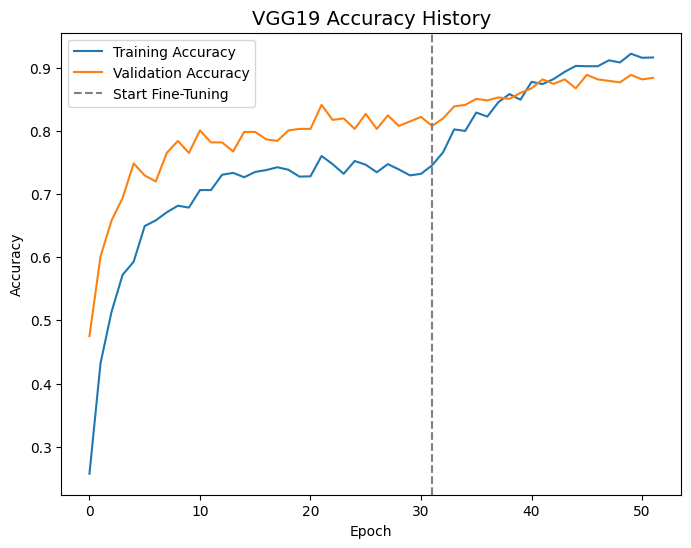


Evaluasi Akhir untuk: VGG19 pada Test Set
--------------------------------------------------
Test Loss: 0.2887
Test Accuracy: 0.9176
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.93      0.93      0.93        14
       glass       0.94      0.88      0.91        17
       metal       0.93      1.00      0.97        14
       paper       0.86      0.95      0.90        20
     plastic       0.94      0.94      0.94        16
       trash       1.00      0.50      0.67         4

    accuracy                           0.92        85
   macro avg       0.93      0.87      0.89        85
weighted avg       0.92      0.92      0.91        85



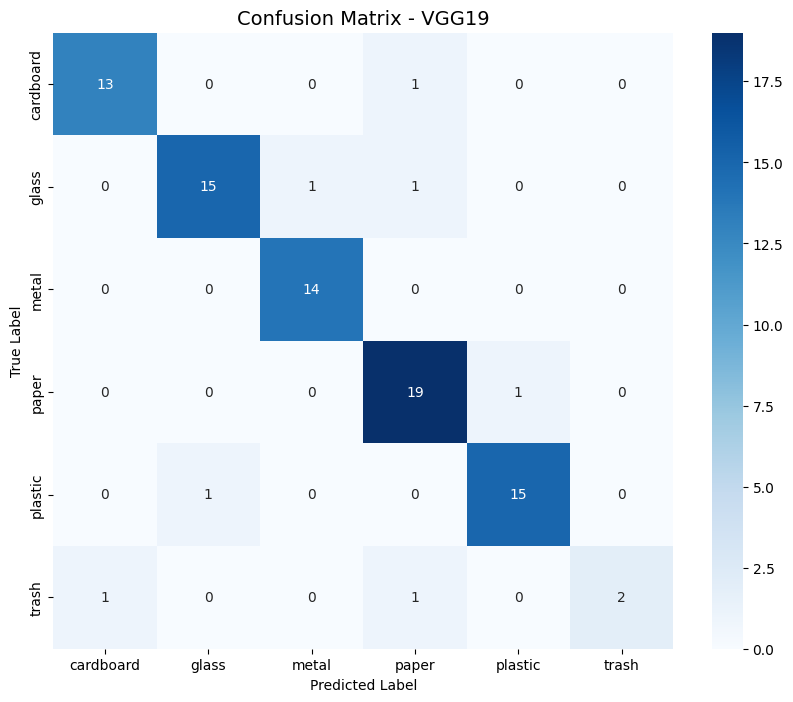


--- Proses untuk model VGG19 Selesai ---


In [11]:
final_results = {}
models_to_run = ['VGG19']

for model_name in models_to_run: # Loop ini sekarang hanya akan berjalan untuk model yang dipilih
    print(f"\n--- Memulai proses untuk model: {model_name} ---")
    model = create_model(model_name=model_name, num_classes=num_classes)
    final_model = run_training_and_finetuning(model, model_name, train_ds, val_ds, class_weight_dict)
    test_loss, test_accuracy = evaluate_final_model(final_model, model_name, test_ds, class_names)
    final_results[model_name] = {'Test Loss': test_loss, 'Test Accuracy': test_accuracy}
    print(f"\n--- Proses untuk model {model_name} Selesai ---")


--- Memulai proses untuk model: ResNet50 ---
Model ResNet50 berhasil dibuat dengan struktur yang benar.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_model          │ (None, 7, 7,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_pool            │ (None, 2048)      │          0 │ base_model[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ avg_pool[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │     12,294 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


Memulai Proses Training untuk: ResNet50
--------------------------------------------------

FASE 1: Initial Training...
Epoch 1/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3851 - loss: 1.9004
Epoch 1: val_accuracy improved from -inf to 0.78860, saving model to models/ResNet50_initial_train_best.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.3870 - loss: 1.8936 - val_accuracy: 0.7886 - val_loss: 0.6093
Epoch 2/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7015 - loss: 0.8947
Epoch 2: val_accuracy improved from 0.78860 to 0.82423, saving model to models/ResNet50_initial_train_best.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7015 - loss: 0.8939 - val_accuracy: 0.8242 - val_loss: 0.5090
Epoch 3/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7421 - loss: 0.7517
Epoch 3: val_accuracy improved from 0.82423 to 0.83610, saving model to models/ResNet50_initial_train_best.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.7424 - l

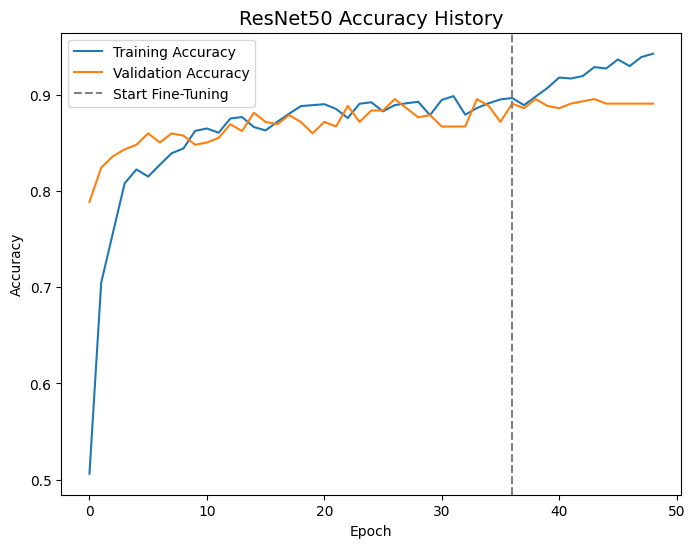


Evaluasi Akhir untuk: ResNet50 pada Test Set
--------------------------------------------------
Test Loss: 0.1565
Test Accuracy: 0.9412
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step

Classification Report:
              precision    recall  f1-score   support

   cardboard       1.00      0.93      0.96        14
       glass       1.00      0.88      0.94        17
       metal       0.82      1.00      0.90        14
       paper       0.95      0.95      0.95        20
     plastic       1.00      0.94      0.97        16
       trash       0.80      1.00      0.89         4

    accuracy                           0.94        85
   macro avg       0.93      0.95      0.94        85
weighted avg       0.95      0.94      0.94        85



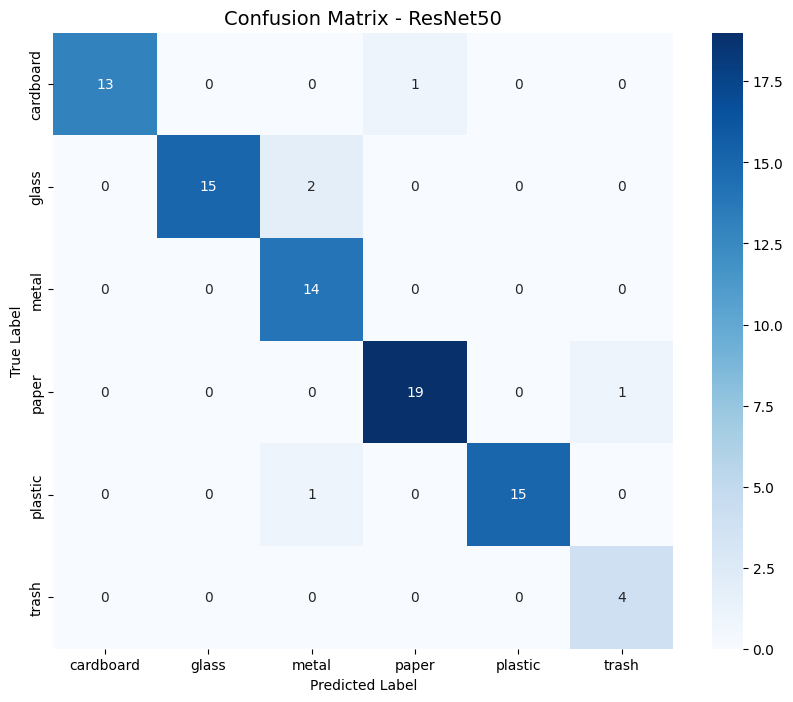


--- Proses untuk model ResNet50 Selesai ---


In [12]:
models_to_run = ['ResNet50']

for model_name in models_to_run:
    print(f"\n--- Memulai proses untuk model: {model_name} ---")
    model = create_model(model_name=model_name, num_classes=num_classes)
    final_model = run_training_and_finetuning(model, model_name, train_ds, val_ds, class_weight_dict)
    test_loss, test_accuracy = evaluate_final_model(final_model, model_name, test_ds, class_names)
    final_results[model_name] = {'Test Loss': test_loss, 'Test Accuracy': test_accuracy}
    print(f"\n--- Proses untuk model {model_name} Selesai ---")


--- Memulai proses untuk model: EfficientNetB0 ---
Model EfficientNetB0 berhasil dibuat dengan struktur yang benar.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_model (Functional)         │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


Memulai Proses Training untuk: EfficientNetB0
--------------------------------------------------

FASE 1: Initial Training...
Epoch 1/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.3860 - loss: 1.5803
Epoch 1: val_accuracy improved from -inf to 0.68884, saving model to models/EfficientNetB0_initial_train_best.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 64s 873ms/step - accuracy: 0.3878 - loss: 1.5762 - val_accuracy: 0.6888 - val_loss: 0.8568
Epoch 2/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.6877 - loss: 0.8843
Epoch 2: val_accuracy improved from 0.68884 to 0.75534, saving model to models/EfficientNetB0_initial_train_best.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 835ms/step - accuracy: 0.6880 - loss: 0.8836 - val_accuracy: 0.7553 - val_loss: 0.6810
Epoch 3/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.7526 - loss: 0.7237
Epoch 3: val_accuracy improved from 0.75534 to 0.77197, saving model to models/EfficientNetB0_initial_train_best.keras
64/64 ━━━━━━━━━━━━━━━━━━━

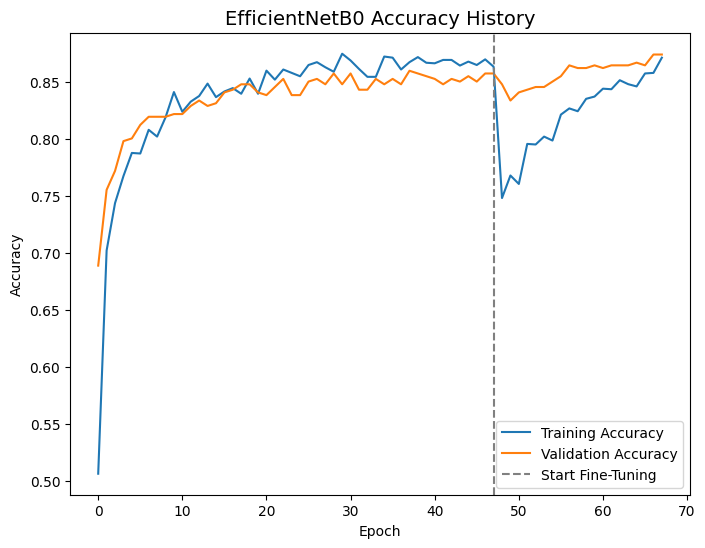


Evaluasi Akhir untuk: EfficientNetB0 pada Test Set
--------------------------------------------------
Test Loss: 0.3508
Test Accuracy: 0.8941
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000013D3BD09240> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step  

Classification Report:
              precision    reca

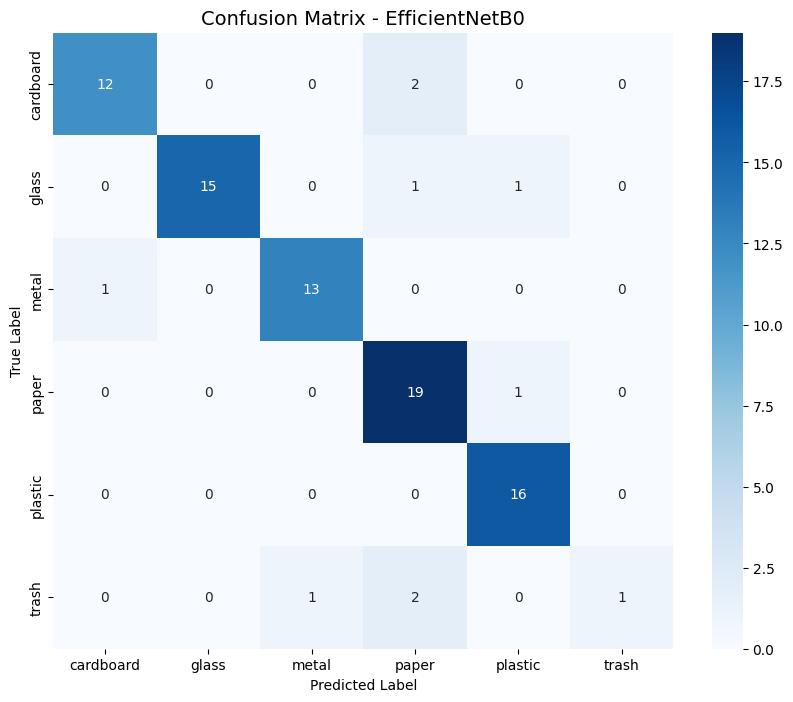


--- Proses untuk model EfficientNetB0 Selesai ---


In [13]:
models_to_run = ['EfficientNetB0']

for model_name in models_to_run:
    print(f"\n--- Memulai proses untuk model: {model_name} ---")
    model = create_model(model_name=model_name, num_classes=num_classes)
    final_model = run_training_and_finetuning(model, model_name, train_ds, val_ds, class_weight_dict)
    test_loss, test_accuracy = evaluate_final_model(final_model, model_name, test_ds, class_names)
    final_results[model_name] = {'Test Loss': test_loss, 'Test Accuracy': test_accuracy}
    print(f"\n--- Proses untuk model {model_name} Selesai ---")


Tabel Perbandingan Performa Model:
                Test Loss Test Accuracy
ResNet50         0.156521        94.12%
VGG19            0.288742        91.76%
EfficientNetB0   0.350820        89.41%


C:\Users\yanst\AppData\Local\Temp\ipykernel_4488\2762219703.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=results_df.index, y=results_df['Test Accuracy'], palette='coolwarm')


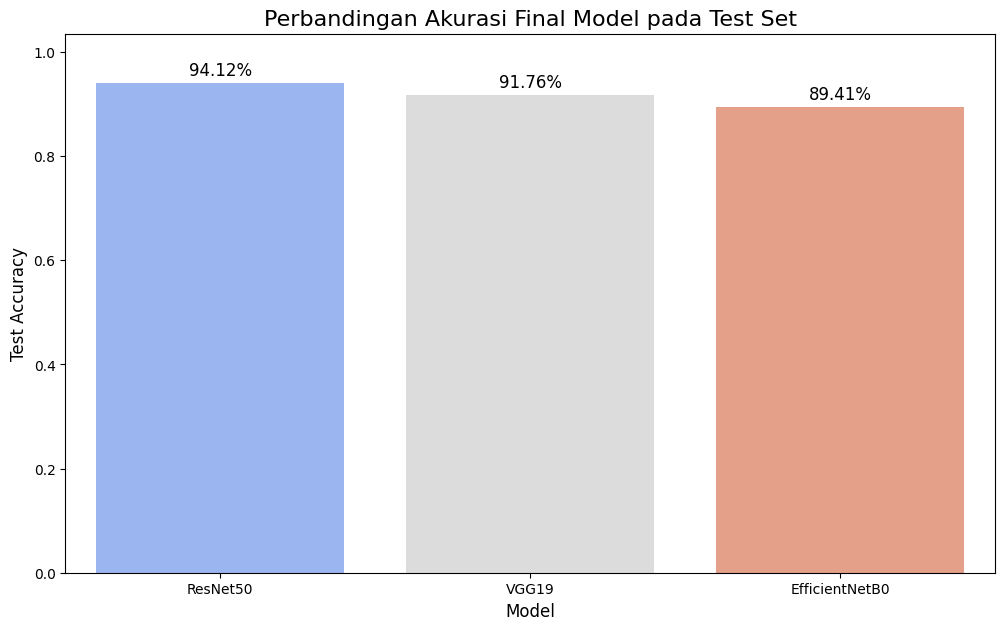


KESIMPULAN:
Berdasarkan hasil evaluasi pada test set, model dengan performa terbaik adalah **ResNet50** dengan akurasi sebesar **94.12%**.


In [14]:
if final_results: # Hanya tampilkan perbandingan jika ada model yang dijalankan
    results_df = pd.DataFrame.from_dict(final_results, orient='index').sort_values(by='Test Accuracy', ascending=False)
    results_df_display = results_df.copy()
    results_df_display['Test Accuracy'] = results_df_display['Test Accuracy'].apply(lambda x: f"{x:.2%}")
    print("\nTabel Perbandingan Performa Model:")
    print(results_df_display)

    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x=results_df.index, y=results_df['Test Accuracy'], palette='coolwarm')
    plt.title('Perbandingan Akurasi Final Model pada Test Set', fontsize=16)
    plt.xlabel('Model', fontsize=12); plt.ylabel('Test Accuracy', fontsize=12)
    plt.ylim(0, max(1.0, results_df['Test Accuracy'].max() * 1.1))
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2%}", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=12)
    plt.show()

    print("\nKESIMPULAN:")
    best_model_name = results_df.index[0]
    best_accuracy = results_df.iloc[0]['Test Accuracy']
    print(f"Berdasarkan hasil evaluasi pada test set, model dengan performa terbaik adalah **{best_model_name}** dengan akurasi sebesar **{best_accuracy:.2%}**.")
else:
    print("Tidak ada model yang dijalankan untuk dibandingkan.")